<a href="https://colab.research.google.com/github/glenrobson/Welsh-Tribunal-annotations/blob/master/TribunalSorter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WW1 Tribunal Archive Image Classifier
This notebook trains an Image Classifier to recognise a limited set of forms which are part of WW1 Tribunal Records. For details on the project see this [blog post](https://glenrobson.github.io/iiif,ai/2020/09/08/image-classifier.html).

### Step 1: Install the Fast AI libraries that are required in subsequent steps:

In [1]:
!pip install -Uqq fastbook

from fastbook import *
from fastai.vision.widgets import *

     |████████████████████████████████| 727kB 4.7MB/s 
     |████████████████████████████████| 51kB 7.1MB/s 
     |████████████████████████████████| 1.0MB 18.5MB/s 
     |████████████████████████████████| 51kB 7.7MB/s 
     |████████████████████████████████| 194kB 30.1MB/s 
     |████████████████████████████████| 40kB 5.8MB/s 
     |████████████████████████████████| 92kB 11.5MB/s 
     |████████████████████████████████| 51kB 8.7MB/s 
     |████████████████████████████████| 61kB 10.4MB/s 
     |████████████████████████████████| 51kB 9.2MB/s 
     |████████████████████████████████| 2.6MB 32.0MB/s 


### Step 2: Prepare the training data.

Firstly download the training images prepared as discussed in the blog.


In [3]:
import requests
response = requests.get("https://iiif.gdmrdigital.com/ww1-tribunal/TribunalTypeImages.zip")
with open("TribunalTypeImages.zip", "wb") as zip_file:
  zip_file.write(response.content)
  zip_file.close()
# saves file in /content directory

Next unzip TribunalTypeImages.zip file so it is ready to train the model. The images and directories are in a format that will hopefully make the training easier. 


In [4]:
import zipfile
with zipfile.ZipFile("TribunalTypeImages.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

!ls images/    

Beige_R186-187_page_1  Beige_R41-42_Page_2  Pink_R43-R44_Page_1
Beige_R186-187_page_2  Blue_R52-53_page_1   Pink_R43-R44_Page_2
Beige_R41-42_Page_1    Blue_R52-53_page_2   Unknown_document_type


Check the images are showing correctly:

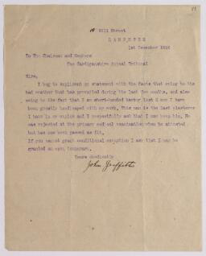

In [5]:
im = Image.open('images/Unknown_document_type/4063227.jpg')
im.to_thumb(256,256)

Finally, check all of the images are valid images as if they aren't then it could throw off the training. With the ZIP file above I found two broken images in the zip file. 

In [10]:
fns = get_image_files('images')
failed = verify_images(fns)
failed


(#0) []

If you do see broken images in the command above, its best to remove them from the training set so as not to confuse things:


In [11]:
failed.map(Path.unlink);

### Step 3: Training

The next step is to train the model. The code below is lifted from the Fast AI course and creates a data structure that links the input files to something that can be given to a trainer. 

The one thing that needed a bit of thought was the resize method. Although the images are roughly the correct size as I request them `255,` in the IIIF request, the model works better with square images and all of the Tribunal records are A4 scans so are rectangles. The Fast AI course goes through a number of methodologies to get square images from rectangles and recommends a random square region from the image. I can see how this would work when you are looking for a bear in a photograph which may not be in the centre but for these images they are mostly consistent and I don't want to miss important parts of the image. Particularly the top left region where the form is sometimes named. 

One of the methods suggested is to fill the extra space caused by the resize with black pixels. This seems the best fit for this data and although the book mentions this is inefficient it seems the best method for this data set. 

As a result of this decision, the images below all have a black border to make them square. 

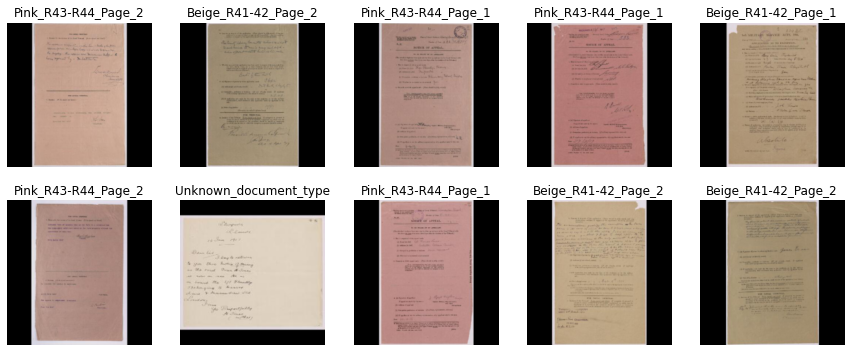

In [9]:
doc_types = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224, ResizeMethod.Pad, pad_mode='zeros'))
dls = doc_types.dataloaders('images')

# Now test:
dls.valid.show_batch(max_n=10, nrows=2)

Now to train the model. This uses a form of cross training. The Resnet18 model is already a model which has been trained to recognise different types of images. We are further training it to recognise our data set. The `fine_tine(4)` means it will go through the dataset 4 times. It takes about 5mins to run and prints out stats as it goes.

One stat to look at is the `error_rate`. A better model will have a value closer to 0. I'm not yet experienced enough to know what a good value looks like yet...


In [12]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,0.681255,0.152393,0.047424,00:43


epoch,train_loss,valid_loss,error_rate,time
0,0.117437,0.067401,0.012881,00:47
1,0.082401,0.078069,0.009953,00:47
2,0.041329,0.070924,0.007611,00:47
3,0.026445,0.070604,0.008197,00:47


Another way to look at the training metrics is to use a confusion matrix. The input data is split into a training set and a validation set. The training set is used to train the model and the validation set is used to test the model with data it hasn't seen yet. The Confusion Matrix plots the correct and incorrect responses using the graph below. A perfect model would have all of the results in a diagonal line from the top left to bottom right. One example from below is there were two pages that were identified as `Beige_R186_187_page_1` when they should have been `Beige_R41-41_Page_1`. 

All in all the numbers incorrectly identified look low to me which is good news. 

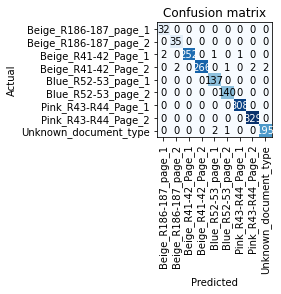

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Another way to look at the training metrics is to look at the top losses. These are the images where the model was most confident of an answer but it was wrong.
 
The results are interesting. Some, like confusing a Beige form with a Pink form look like the source data is incorrect. For the others its difficult to see if its right or wrong at this resolution. It would be useful if it printed out the filename of the images so I could link to the IIIF image to see which are which.



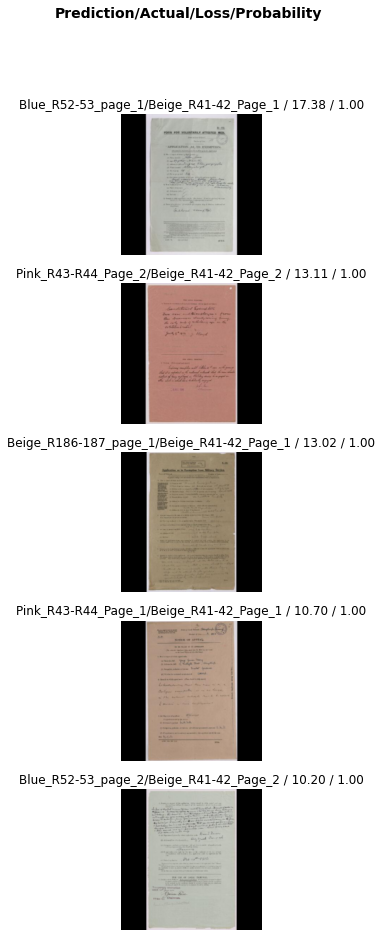

In [16]:
interp.plot_top_losses(5, nrows=5)

### Step 4: Testing and evaluation

The final step is to test it with new data. As all of the NLW images have been transcribed I list below some Tribunal records from other sources. Once run, the code below will ask you to paste in a URL to an image which it will try and identify. 

In [15]:
url = input('Enter a URL to an image to analyse: ')
response = requests.get(url)
with open("testimage.jpg", "wb") as image_file:
  image_file.write(response.content)
  image_file.close()

learn.predict("testimage.jpg")

Enter a URL to an image to analyse: https://iiif.gdmrdigital.com/ww1-tribunal/tna_images/R41-p1.png


('Beige_R41-42_Page_1',
 tensor(2),
 tensor([8.2739e-05, 4.1119e-06, 9.9971e-01, 3.9391e-05, 4.9900e-05, 1.4515e-06, 1.9471e-08, 1.4810e-08, 1.1404e-04]))

Example images:
 * https://live.staticflickr.com/8371/8417587718_9e0a275899.jpg from Manchester: https://www.flickr.com/photos/manchesterarchiveplus/8417587718/in/album-72157632619308865/ (Answer should be Blue_R52-53_page_1)
 * https://iiif.gdmrdigital.com/ww1-tribunal/tna_images/R41-p1.png from https://discovery.nationalarchives.gov.uk/details/r/C14091136 (Answer should be Beige_R41-42_Page_1)
 *  https://iiif.gdmrdigital.com/ww1-tribunal/tna_images/R41-p2.png from https://discovery.nationalarchives.gov.uk/details/r/C14091136 (Answer should be Beige_R41-42_Page_2)

The following form types are in the TNA but not the NLW collection and it correctly identifies it as Unknown:
 *  https://iiif.gdmrdigital.com/ww1-tribunal/tna_images/R57-p1.png
 * https://iiif.gdmrdigital.com/ww1-tribunal/tna_images/R58.png

For the next one it identifies it as 'Beige_R186-187_page_1' 
 * https://iiif.gdmrdigital.com/ww1-tribunal/tna_images/R43-p1.png

although the form says on it is a R43 form. The R43 forms in the NLW collection are Pink (Pink_R43-R44_Page_1) so its not surprising this confused the model.

Finally if you want to, you can save the Model:

In [ ]:
learn.export()